In [1]:
import os, sys

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.signal import freqz, sosfreqz, sosfilt, coherence
from scipy.signal import butter, lfilter
import librosa

In [3]:
from dsp import resample
from dsp import load_fir, load_sos, sos_to_fir
from dsp import firfilt, xfilt
from dsp import spectral_args
from dsp import attenuation

In [4]:
from anc.simulation import anc_simulation

In [5]:
spectral_args

{'fs': 192000,
 'window': 'hann',
 'nperseg': 16384,
 'noverlap': 8192,
 'nfft': 16384,
 'detrend': False,
 'return_onesided': True,
 'scaling': 'spectrum'}

In [6]:
fs = 192000
nfft = 2048

# load FF & FB

In [7]:
path_ff = "results/ff.csv"
path_fb = "results/fb.csv"

ff_sos = load_sos(path_ff)
fb_sos = load_sos(path_fb)

### convert SOS for FIR

In [8]:
FF = sos_to_fir(ff_sos, 4096)
FB = sos_to_fir(fb_sos, 4096)

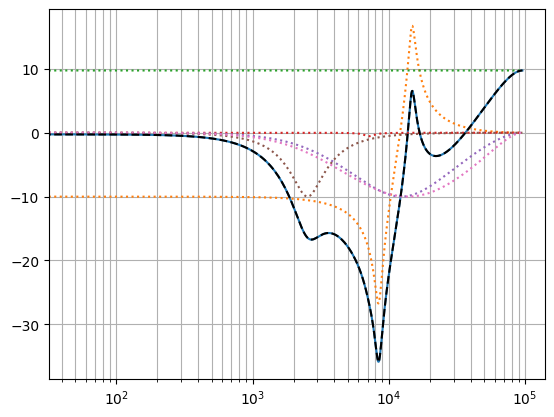

In [9]:
w, h = sosfreqz(ff_sos, worN=nfft, whole=False, fs=fs)
plt.semilogx(w, 20 * np.log10(np.abs(h)));

for i in range(len(ff_sos)):
    w, h = sosfreqz(ff_sos[i], worN=nfft, whole=False, fs=fs)
    plt.semilogx(w, 20 * np.log10(np.abs(h)), ":");

w, h = freqz(FF, a=1, worN=nfft, whole=False, fs=fs)
plt.semilogx(w, 20 * np.log10(np.abs(h)), "k--");

plt.grid(which="both");
# plt.xlim(10, 20000);

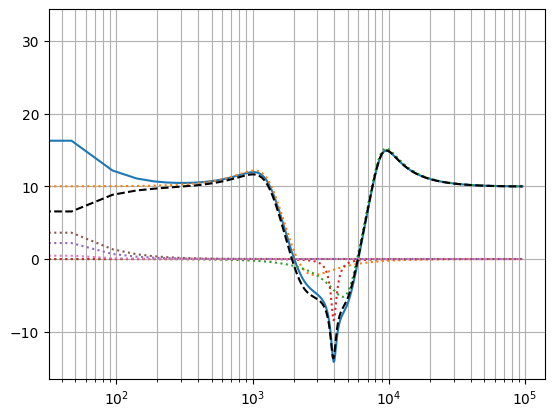

In [10]:
w, h = sosfreqz(fb_sos, worN=nfft, whole=False, fs=fs)
plt.semilogx(w, 20 * np.log10(np.abs(h)));

for i in range(len(fb_sos)):
    w, h = sosfreqz(fb_sos[i], worN=nfft, whole=False, fs=fs)
    plt.semilogx(w, 20 * np.log10(np.abs(h)), ":");

w, h = freqz(FB, a=1, worN=nfft, whole=False, fs=fs)
plt.semilogx(w, 20 * np.log10(np.abs(h)), "k--");

plt.grid(which="both");
# plt.xlim(10, 20000);

# load PP & SP

In [11]:
dataset_path = "/home/alexey/Documents/python/github/active-noise-control/datasets/PANDAR"

fs_data = 48000

path_pp = f"{dataset_path}/PP/PP_PersonID7_L_normal.txt"
path_sp = f"{dataset_path}/SP/SP_PersonID7_L_normal.txt"

PP_48k = load_fir(path_pp)
SP_48k = load_fir(path_sp)

PP = resample(PP_48k, fs=fs_data, fs_new=fs)
SP = resample(SP_48k, fs=fs_data, fs_new=fs)

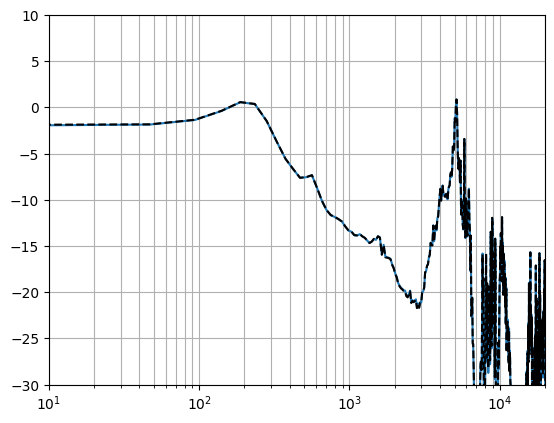

In [12]:
w, h = freqz(PP_48k, a=1, worN=512, whole=False, fs=fs_data)
plt.semilogx(w, 20 * np.log10(np.abs(h)));

w, h = freqz(PP, a=1, worN=2048, whole=False, fs=fs)
plt.semilogx(w, 20 * np.log10(np.abs(h)), "k--");

plt.grid(which="both");
plt.xlim(10, 20000);
plt.ylim(-30, 10);

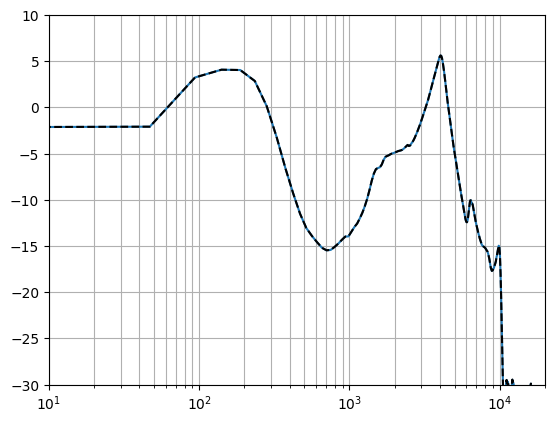

In [13]:
w, h = freqz(SP_48k, a=1, worN=512, whole=False, fs=fs_data)
plt.semilogx(w, 20 * np.log10(np.abs(h)));

w, h = freqz(SP, a=1, worN=2048, whole=False, fs=fs)
plt.semilogx(w, 20 * np.log10(np.abs(h)), "k--");

plt.grid(which="both");
plt.xlim(10, 20000);
plt.ylim(-30, 10);

# ANC simulation

In [14]:
duration = 2 # sec
length = int(duration * fs)

In [15]:
# generate PP data
np.random.seed(0)

ref = np.random.randn(length)
noise = np.random.randn(*ref.shape) * 0.03
erp = firfilt(PP, ref) + noise

In [16]:
# b, a = butter(4, 20 / (fs / 2), "highpass", analog=False)
# erp = lfilter(b, a, erp)

In [17]:
spectral_args_coh = spectral_args.copy()

spectral_args_coh["fs"] = fs
spectral_args_coh["nperseg"] = 16384
spectral_args_coh["nfft"] = 16384
del spectral_args_coh["return_onesided"]
del spectral_args_coh["scaling"]

In [18]:
f, Cxy = coherence(ref, erp, **spectral_args_coh)
coh_limit = 10 * np.log10(1 - Cxy.ravel())

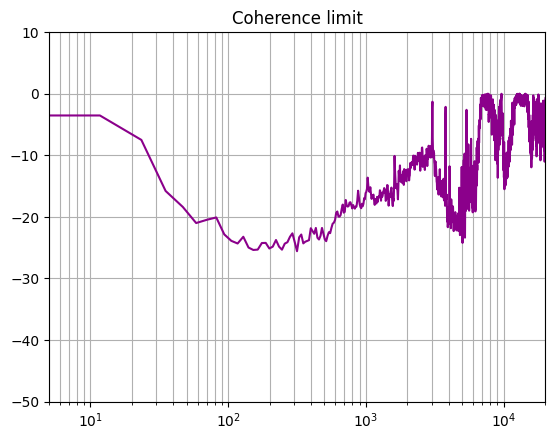

In [19]:
plt.semilogx(f, coh_limit, color="darkmagenta");

plt.grid(which="both");
plt.xlim(5, 20000);
plt.ylim(-50, 10);
plt.title("Coherence limit");

In [20]:
# erp_ff = firfilt(SP, firfilt(FF, ref))
erp_ff = firfilt(SP, xfilt(ff_sos, ref)[0])

f, att_ff = attenuation(erp_ff - erp, erp, **spectral_args)

In [21]:
# erp_fb = anc_simulation(None, erp, None, FB, SP, verbose=True)
erp_fb = anc_simulation(None, erp, None, fb_sos, SP, verbose=True)

f, att_fb = attenuation(erp_fb - erp, erp, **spectral_args)

100%|██████████████████████████████████████████| 384000/384000 [01:17<00:00, 4948.58it/s]


In [22]:
# erp_fffb = anc_simulation(ref, erp, FF, FB, SP, verbose=True)
# erp_fffb = anc_simulation(ref, erp, ff_sos, fb_sos, SP, verbose=True)
# f, att_fffb = attenuation(erp_fffb - erp, erp, **spectral_args)

att_fffb = att_ff + att_fb # approximation at ERP

/tmp/ipykernel_116519/4064329374.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 20000);


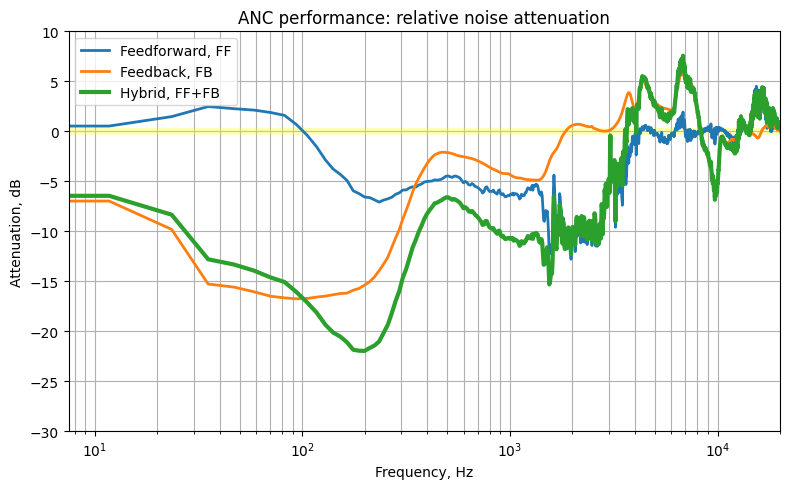

In [23]:
plt.figure(figsize=(8, 5));

# plt.semilogx(f, coh_limit, color="darkmagenta", linewidth=0.5, label="coh limit");

plt.semilogx(f, np.zeros_like(f), color="yellow", linewidth=5, alpha=0.3);

plt.semilogx(f, att_ff, label="Feedforward, FF", linewidth=2);
plt.semilogx(f, att_fb, label="Feedback, FB", linewidth=2);
plt.semilogx(f, att_fffb, label="Hybrid, FF+FB", linewidth=3);

plt.grid(which="both");
plt.xlim(0, 20000);
plt.ylim(-30, 10);
plt.legend();
plt.title("ANC performance: relative noise attenuation");
plt.xlabel("Frequency, Hz");
plt.ylabel("Attenuation, dB");

plt.tight_layout();
plt.savefig(f"attenuation.png", dpi=300); # move to /images

In [24]:
# w, h = freqz(PP, a=1, worN=2048, whole=False, fs=fs)
# PP_mag = 20 * np.log10(np.abs(h))
# plt.semilogx(w, PP_mag);

# w, h = freqz(SP, a=1, worN=2048, whole=False, fs=fs)
# SP_mag = 20 * np.log10(np.abs(h))
# plt.semilogx(w, SP_mag);

# FF_mag_estimate = PP_mag - SP_mag
# plt.semilogx(w, FF_mag_estimate);

# w, h = freqz(FF, a=1, worN=nfft, whole=False, fs=fs)
# FF_mag = 20 * np.log10(np.abs(h))
# plt.semilogx(w, FF_mag, "k--");

# plt.grid(which="both");
# plt.xlim(10, 30000);
# plt.ylim(-30, 10);